# Week09b - 7주차 머신러닝 실습 

### 실습 1. 데이터 정제 및 시각화

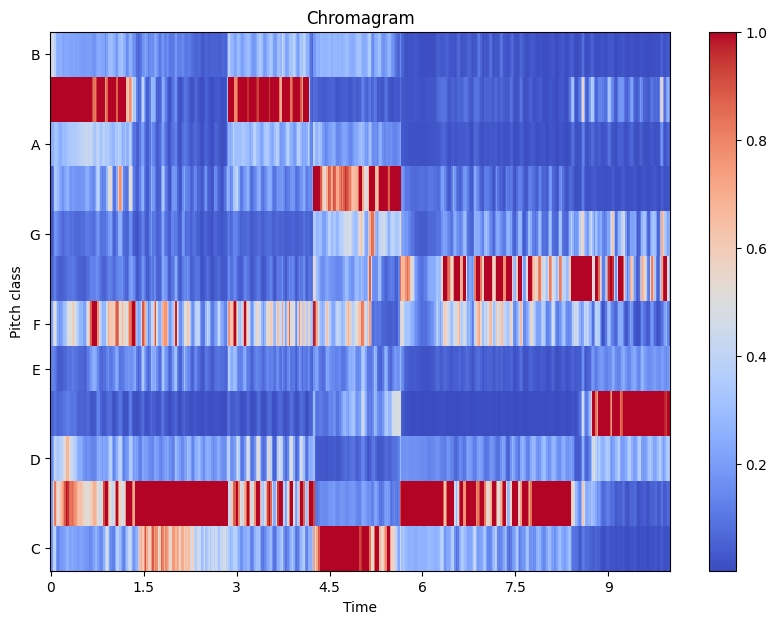

[[0.12695196 0.10969536 0.14811414 ... 0.36187467 1.         0.41807705]
 [0.17195855 0.18632539 0.14620444 ... 0.25014704 1.         0.45328695]
 [0.40766805 0.5425652  0.24189611 ... 0.2570825  1.         0.48235983]
 ...
 [0.01699875 0.05394857 0.3411202  ... 0.03695491 0.19440097 0.03188943]
 [0.01693157 0.06516949 0.35548183 ... 0.0587565  0.2535109  0.03460428]
 [0.03094667 0.07593377 0.345949   ... 0.05159916 0.1826136  0.03209169]]
---------------------------
[146.84232  272.64093   85.74631   78.054825  48.98002  158.15355
 146.5383    74.091194  96.245766  58.80615  133.96158   56.9632  ]


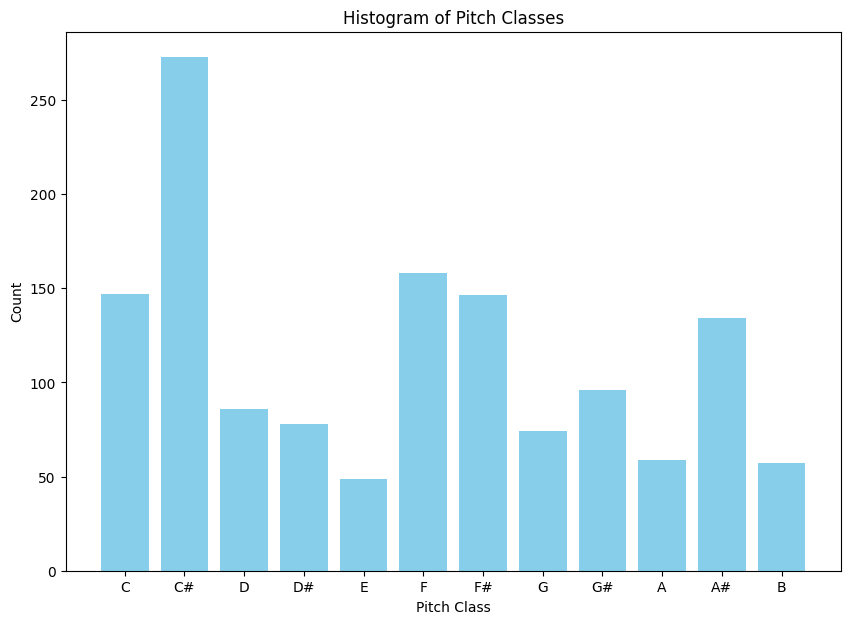

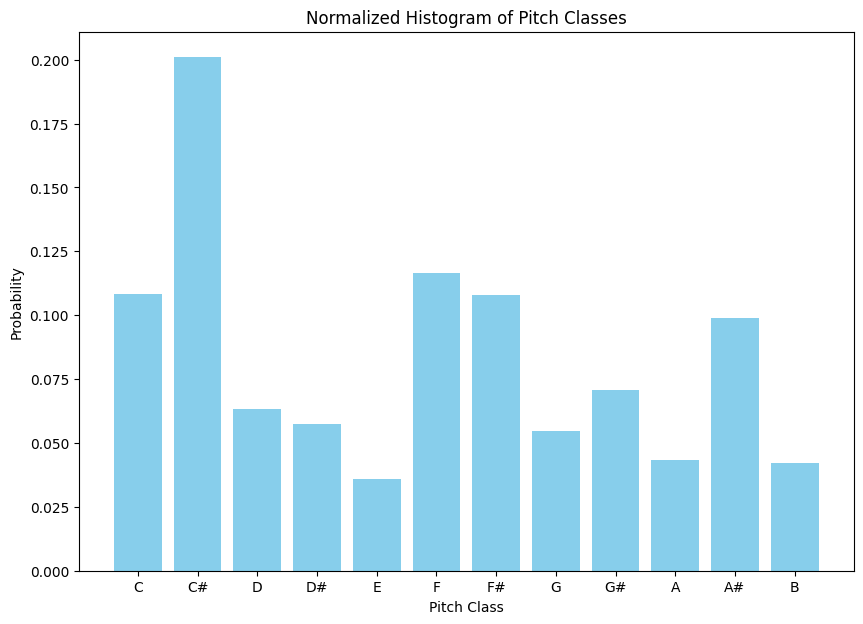

In [1]:
import os
import glob

directory = "./music"
full_path_wav = glob.glob(os.path.join(directory, "*.wav")) # os.path 는 현제 ipynb파일이 있는 곳이 기준 경로로 설정되어 있음

wav_file = full_path_wav[0] # 첫번째 파일만 선택

import librosa
waveform, sample_rate = librosa.load(wav_file, sr=None, duration=10) # 10s까지 오디오 파일에서 10초 분량의 신호를 추출
resample_rate = sample_rate / 2 # resampling = 1/2 with respect to original sample rate
resampled = librosa.resample(waveform, orig_sr=sample_rate, target_sr=resample_rate) # 오디오의 속도를 절반으로 절감

# 프레임 길이 100ms 설정 : sr*2205
chromagram = librosa.feature.chroma_stft(y=resampled, n_fft=2205, sr=resample_rate, hop_length=512) # 크로마그램은 시간

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
librosa.display.specshow(chromagram, x_axis="time", y_axis="chroma", cmap="coolwarm")
plt.colorbar()
plt.title("Chromagram")
plt.show()

# 크로마그램 특징벡터 - 히스토그램
import numpy as np
chromagram_vectors = chromagram.T  
print(chromagram_vectors)
pitch_class_energy = np.sum(chromagram_vectors, axis=0)
print("---------------------------")
print(pitch_class_energy)
plt.figure(figsize=(10, 7))
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.bar(pitch_classes, pitch_class_energy, color='skyblue')
plt.xlabel('Pitch Class')
plt.ylabel('Count')
plt.title('Histogram of Pitch Classes')
plt.show()

# 히스토그램 정규화
pitch_class_energy = np.sum(chromagram_vectors, axis=0)
normalized_pitch_class_energy = pitch_class_energy / np.sum(pitch_class_energy)
plt.figure(figsize=(10, 7))
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.bar(pitch_classes, normalized_pitch_class_energy, color='skyblue')
plt.xlabel('Pitch Class')
plt.ylabel('Probability')
plt.title('Normalized Histogram of Pitch Classes')
plt.show()

### 실습 2. 다양한 소리의 특징 백터 - 결과 그래프

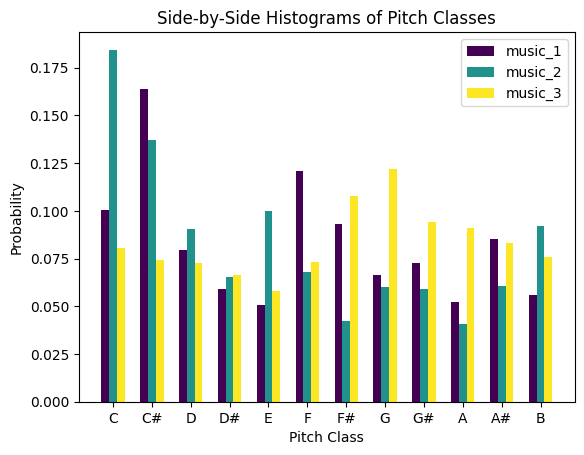

In [2]:
import os 
import glob

directory = "./music"
full_path_wav = glob.glob(os.path.join(directory, "*.wav")) # os.path 는 현제 ipynb파일이 있는 곳이 기준 경로로 설정되어 있음

wav_file = full_path_wav[0:3] # 3개 추출

import librosa
import numpy as np

hop_length = 512
# 크로마그램과 리샘플, 히스토그램
def compute_normalized_histogram(wav_file, hop_length=hop_length):
    waveform, sample_rate = librosa.load(wav_file, sr=None, duration=10) # 10s까지
    sample_rate = sample_rate / 2
    resampled = librosa.resample(waveform, orig_sr=sample_rate, target_sr=resample_rate)
    chromagram = librosa.feature.chroma_stft(y=resampled, n_fft=2205, sr=resample_rate, hop_length=hop_length)
    chromagram_vectors = chromagram.T
    pitch_class_energy = np.sum(chromagram_vectors, axis=0)
    normalized_pitch_class_energy = pitch_class_energy / np.sum(pitch_class_energy)
    return normalized_pitch_class_energy

pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
# 막대바의 폭
bar_width = 0.2
bar_positions = np.arange(len(pitch_classes))

import matplotlib.pyplot as plt
# matplotlib의 컬러맵에서 자동으로 색상 설정
colors = plt.cm.viridis(np.linspace(0, 1, len(wav_file)))
for i, (wav_file, color) in enumerate(zip(wav_file, colors)):
    normalized_histogram = compute_normalized_histogram(wav_file)
    positions = bar_positions + i * bar_width
    plt.bar(positions, normalized_histogram, width=bar_width, color=color, label=f"music_{i+1}")

plt.xlabel('Pitch Class')
plt.ylabel('Probability')
plt.title('Side-by-Side Histograms of Pitch Classes')
plt.xticks(bar_positions + bar_width, pitch_classes) 
plt.legend(loc='upper right') 
plt.show()

### 실습 3. K-Means 클러스트링 코드

cellos-down-down.wav: 3
cello_01_engine.wav: 3
cooking-indrustrial-music-loop-mastering.wav: 2
duisterwho__deep-house-music-loop.wav: 2
happy-birthday.wav: 3
keweldog__piano2.wav: 1
kyster__church-viking-music.wav: 2
lemoncreme__ambient-piano-music-3.wav: 3
music_1.wav: 2
music_2.wav: 3
orchestral-strings-warm-a.wav: 1
timouse__melodic-beat-220619.wav: 2


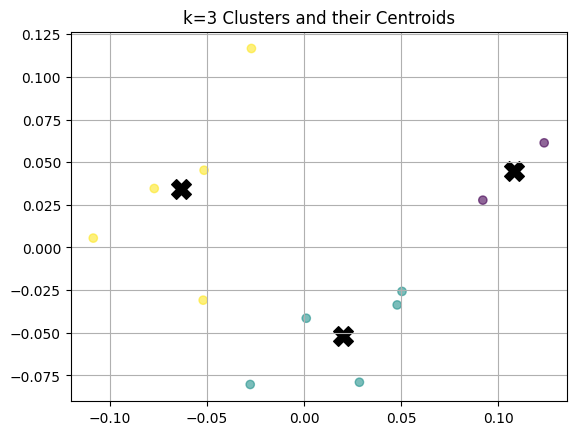

In [3]:
import os 
import glob

directory = "./music"
full_path_wav = glob.glob(os.path.join(directory, "*.wav")) # os.path 는 현제 ipynb파일이 있는 곳이 기준 경로로 설정되어 있음

wav_file = full_path_wav[:] # 모두 선택

import librosa
import numpy as np

hop_length = 512
# 크로마그램과 리샘플, 히스토그램
def compute_normalized_histogram(wav_file, hop_length=hop_length):
    waveform, sample_rate = librosa.load(wav_file, sr=None, duration=10) # 10s까지
    sample_rate = sample_rate / 2
    resampled = librosa.resample(waveform, orig_sr=sample_rate, target_sr=resample_rate)
    chromagram = librosa.feature.chroma_stft(y=resampled, n_fft=2205, sr=resample_rate, hop_length=hop_length)
    chromagram_vectors = chromagram.T
    pitch_class_energy = np.sum(chromagram_vectors, axis=0)
    normalized_pitch_class_energy = pitch_class_energy / np.sum(pitch_class_energy)
    return normalized_pitch_class_energy

pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
histograms = np.array([compute_normalized_histogram(wav_file) for wav_file in full_path_wav])

from sklearn.cluster import KMeans
n_kClusters = 3 # 클러스트 개수(k수)
kmeans = KMeans(n_clusters=n_kClusters, init="k-means++", max_iter=5000, n_init=10, random_state=42)
history = kmeans.fit_predict(histograms)

cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

for i, label in enumerate(cluster_labels):
    print(os.path.basename(wav_file[i])+f": {label+1}")

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2D 그래프 #PCA(n_components=2)는 데이터를 2차원으로 축소하기 위해 설정합니다.그래프로 표현하기 위해 
reduced_features  = pca.fit_transform(histograms) #데이터에 PCA를 적용하여 2차원 특징 벡터로 변환
reduced_centroids = pca.transform(centroids)#각 클러스터의 중심(centroid)도 같은 PCA
unique_labels = np.unique(cluster_labels) #라벨 확인
plt.scatter([reduced_features[:, 0]], [reduced_features[:, 1]], c=cluster_labels, alpha=0.6)
plt.scatter([reduced_centroids[:, 0]], [reduced_centroids[:, 1]], c='black', marker='X',s=200)
plt.title('k='+f'{n_kClusters}'+' Clusters and their Centroids')
plt.grid()
plt.show()

### 실습 4. SOM_Colormap

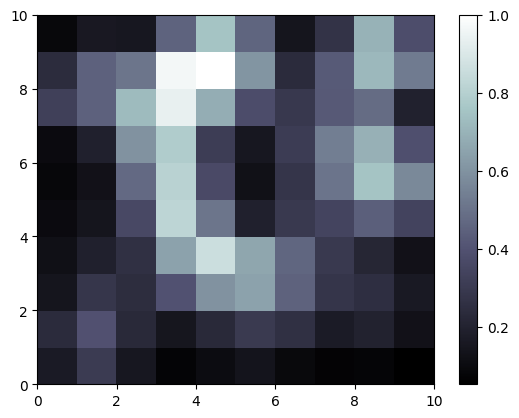

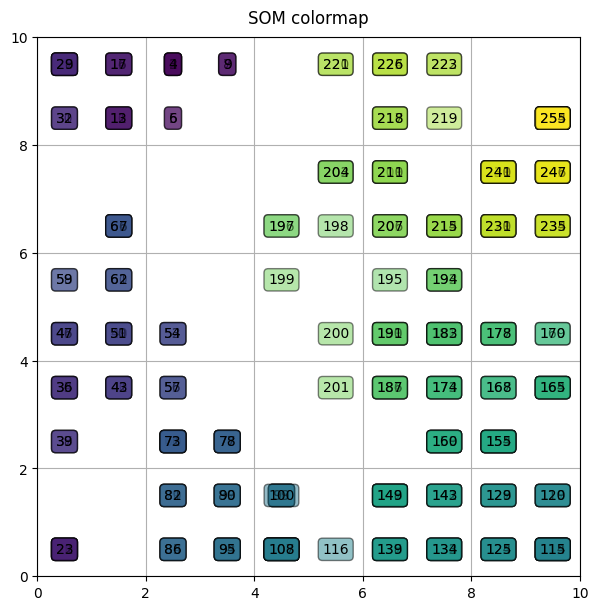

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from minisom import MiniSom

# "Viridis" 컬러 맵에서 256개의 RGB 데이터를 추출
colormap = cm.get_cmap("viridis", 256)

# RGB 데이터를 추출하고 0-1 사이로 정규화
colormap_data = colormap(np.arange(256))[:, :3]

# SOM 모델 설정 (10x10 그리드, 입력 차원 3(RGB))
som = MiniSom(x=10, y=10, input_len=3, sigma=1.0, learning_rate=0.5)

# SOM 초기화 및 학습
som.random_weights_init(colormap_data)
som.train_random(colormap_data, 1000) # 1000회 반복 학습

# 결과 시각화
plt.figure()
plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar()
plt.figure(figsize=(7, 7))
for i, x in enumerate(colormap_data):
    w = som.winner(x)
    plt.text(w[0] + 0.5, w[1] + 0.5, str(i), ha='center', va='center',
             bbox=dict(facecolor=x, alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))
plt.xlim([0, som.get_weights().shape[0]])
plt.ylim([0, som.get_weights().shape[1]])
plt.grid()
plt.title('SOM colormap',pad=10)
plt.show()

### 실습 4. SOM_iris 결과

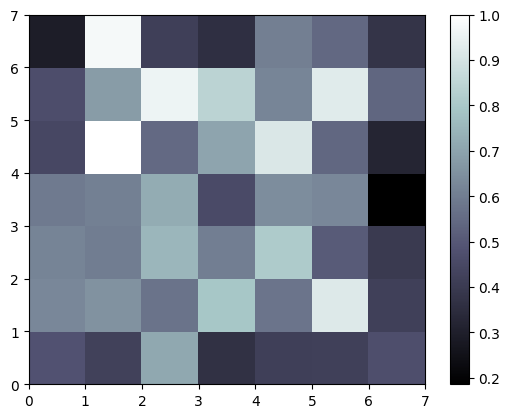

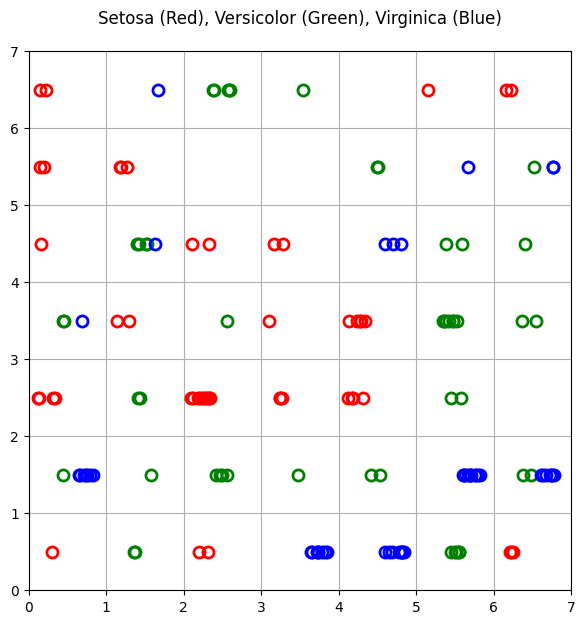

In [5]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
data = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
target = iris["target"]
# iris-setosa == 0, iris-versicolor == 1, iris-virginica == 2
# 각 열에 대해 개별적으로 정규화 (열 단위 최댓값으로 나누기)
data = data.apply(lambda x : x / x.max(), axis=0)
data = np.array(data)

som = MiniSom(7, 7, 4, sigma=0.1, learning_rate=0.0001)
som.random_weights_init(data)
som.train_random(data, 1000) # 1000회 반복 학습
data.shape

# 결과 시각화
plt.figure()
plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar()
plt.show()

markers = ['o', 'o', 'o']
colors = ['r', 'g', 'b'] 
plt.figure(figsize=(7, 7))
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # 해당 데이터의 BMU
    plt.plot(w[0]+.1+0.005*cnt, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
              markeredgecolor=colors[target[cnt]], markersize=8, markeredgewidth=2)
plt.title('Setosa (Red), Versicolor (Green), Virginica (Blue)', pad=20)
plt.xlim([0, som.get_weights().shape[0]])
plt.ylim([0, som.get_weights().shape[1]])
plt.grid()
plt.show()